## Predicción de Personalidad - Modelo Base y Ensamble Simple
#### **Parte 1**

Fecha: 28 julio 2025

**Autor: Ricardo Urdaneta**

#### Objetivo
El objetivo es desarrollar un modelo de clasificación robusto para predecir si una persona es introvertida o extrovertida basándose en sus respuestas a un cuestionario. Este es el primer enfoque del problema, centrado en establecer una línea base sólida.

#### Metodología

Análisis Exploratorio de Datos (EDA) para entender la distribución y las relaciones en los datos.

Preprocesamiento de datos, destacando el manejo de valores nulos mediante imputación por la mediana, una técnica rápida y robusta.

Entrenamiento de un modelo **`RandomForestClassifier`** como línea base.

Optimización de hiperparámetros utilizando **`GridSearchCV`**.

Creación de un ensamble simple con **`VotingClassifier`** para combinar las predicciones de RandomForest, XGBoost y LightGBM.

In [1]:
# Para manipulación de datos
import pandas as pd
import numpy as np

# Para preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Para visualización 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar el archivo CSV
df_train = pd.read_csv('train.csv')
# Muestra las primeras 5 filas del dataframe
df_train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [3]:
# Información general del dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [7]:
# Crear una copia fresca y eliminar la columna 'id'
df_processed = df_train.copy()
df_processed = df_processed.drop('id', axis=1)

# Lista de columnas que realmente son 'Yes'/'No'
cols_to_map = ['Stage_fear', 'Drained_after_socializing']

for col in cols_to_map:
    df_processed[col] = df_processed[col].map({'Yes': 1, 'No': 0})

# Codificar la variable objetivo
le = LabelEncoder()
df_processed['Personality'] = le.fit_transform(df_processed['Personality'])

# Rellenar TODOS los valores faltantes con la mediana de su columna
for column in df_processed.columns:
    if df_processed[column].isnull().any():
        median_value = df_processed[column].median()
        df_processed[column] = df_processed[column].fillna(median_value)

# VERIFICACIÓN FINAL
print("--- Verificación Final ---")
print(df_processed.info())
print("--------------------------\n")


--- Verificación Final ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           18524 non-null  float64
 1   Stage_fear                 18524 non-null  float64
 2   Social_event_attendance    18524 non-null  float64
 3   Going_outside              18524 non-null  float64
 4   Drained_after_socializing  18524 non-null  float64
 5   Friends_circle_size        18524 non-null  float64
 6   Post_frequency             18524 non-null  float64
 7   Personality                18524 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.1 MB
None
--------------------------



In [8]:
# Describir el dataframe para obtener estadísticas básicas
df_processed.describe()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
count,18524.000000,18524.000000,18524.000000,18524.000000,18524.000000,18524.000000,18524.000000,18524.000000
mean,3.064673,0.217124,5.248219,4.040812,0.219283,7.996923,4.983319,0.260473
std,2.919057,0.412299,2.665002,1.979312,0.413772,4.101561,2.779172,0.438905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,3.000000,0.000000,5.000000,3.000000,0.000000
50%,2.000000,0.000000,5.000000,4.000000,0.000000,8.000000,5.000000,0.000000
75%,4.000000,0.000000,7.000000,6.000000,0.000000,11.000000,7.000000,1.000000
max,11.000000,1.000000,10.000000,7.000000,1.000000,15.000000,10.000000,1.000000


🚀 Generando mapa de calor...


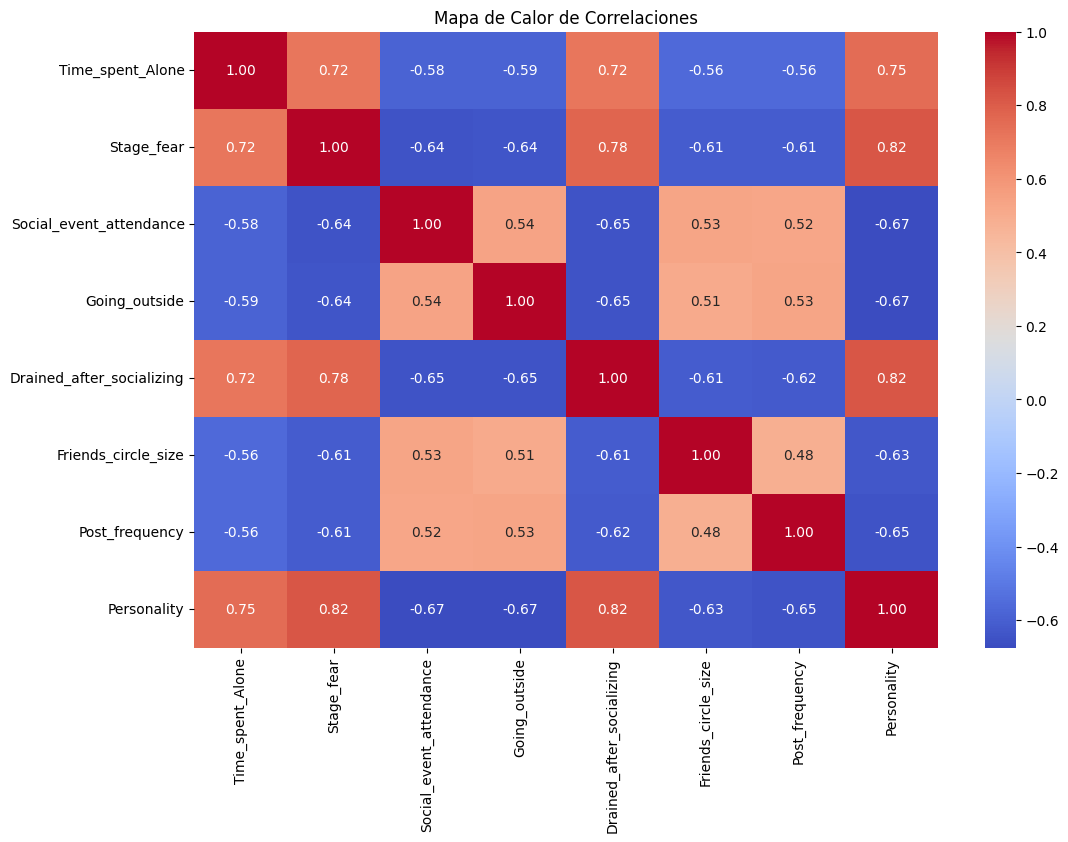

In [5]:
# Generar el mapa de calor
print("🚀 Generando mapa de calor...")
plt.figure(figsize=(12, 8))
sns.heatmap(df_processed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Calor de Correlaciones')
plt.show()

Personality
0    13699
1     4825
Name: count, dtype: int64


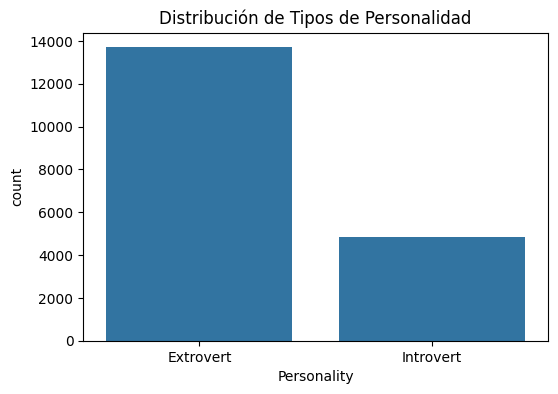

In [6]:
# Contar los valores de la variable 'Personality'
personality_counts = df_processed['Personality'].value_counts()
print(personality_counts)

# Graficar la distribución
plt.figure(figsize=(6, 4))
sns.countplot(x='Personality', data=df_processed)
plt.title('Distribución de Tipos de Personalidad')
# Usamos las clases de LabelEncoder para las etiquetas del eje x
plt.xticks(ticks=[0, 1], labels=le.classes_)
plt.show()

---

### 1. Modelado Inicial y Optimización con RandomForest

In [7]:
# Separar los datos en características (X) y objetivo (y)
X = df_processed.drop('Personality', axis=1)
y = df_processed['Personality']

# Dividir los datos en conjuntos de entrenamiento y prueba
# Usamos stratify=y para asegurar que la proporción de introvertidos/extrovertidos sea la misma en ambos conjuntos, lo cual es crucial por el desbalance.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Datos divididos en entrenamiento y prueba.")
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")

# Crear y entrenar el modelo Random Forest
# Usamos class_weight='balanced' para que el modelo preste más atención a la clase minoritaria (introvertidos) y no se deje llevar por la mayoría.
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

print("\nEntrenando el modelo Random Forest...")
rf_model.fit(X_train, y_train)
print("¡Modelo entrenado!")

# Hacer predicciones y evaluar el modelo
print("\nEvaluando el modelo en el conjunto de prueba...")
y_pred = rf_model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy (Precisión) del modelo: {accuracy:.4f}")

# Mostrar el reporte de clasificación con precision, recall y f1-score
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Extrovert', 'Introvert']))

Datos divididos en entrenamiento y prueba.
Tamaño de X_train: (14819, 7)
Tamaño de X_test: (3705, 7)

Entrenando el modelo Random Forest...
¡Modelo entrenado!

Evaluando el modelo en el conjunto de prueba...

Accuracy (Precisión) del modelo: 0.9655

Reporte de Clasificación:
              precision    recall  f1-score   support

   Extrovert       0.98      0.97      0.98      2740
   Introvert       0.92      0.95      0.93       965

    accuracy                           0.97      3705
   macro avg       0.95      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



In [8]:
# Definir la parrilla de parámetros a probar
param_grid = {
    'n_estimators': [100, 200],         # Número de árboles en el bosque
    'max_depth': [10, 20, None],        # Profundidad máxima de los árboles
    'min_samples_leaf': [1, 2, 4]       # Mínimo de muestras en un nodo hoja
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

print("Iniciando GridSearchCV... Esto puede tardar varios minutos.")
# Entrenamos la búsqueda sobre el conjunto de entrenamiento completo
grid_search.fit(X_train, y_train)

print("\nGridSearchCV completado.")
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")
print(f"Mejor score de cross-validation (accuracy): {grid_search.best_score_:.4f}")

Iniciando GridSearchCV... Esto puede tardar varios minutos.
Fitting 5 folds for each of 18 candidates, totalling 90 fits

GridSearchCV completado.
Mejores parámetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 100}
Mejor score de cross-validation (accuracy): 0.9678


In [9]:
# Cargar el dataset de test original
df_test = pd.read_csv('test.csv')
# Guardar los IDs para el archivo de submission
test_ids = df_test['id']

# APLICAR EL MISMO PREPROCESAMIENTO AL TEST SET
df_test_processed = df_test.copy()
df_test_processed = df_test_processed.drop('id', axis=1)

# Convertir Stage_fear 
df_test_processed['Stage_fear'] = pd.to_numeric(df_test_processed['Stage_fear'], errors='coerce')

# Mapear columnas categóricas
cols_to_map = ['Stage_fear', 'Drained_after_socializing']
for col in cols_to_map:
    df_test_processed[col] = df_test_processed[col].map({'Yes': 1, 'No': 0})

# Rellenar nulos usando la mediana del set DE ENTRENAMIENTO
for column in df_test_processed.columns:
    if df_test_processed[column].isnull().any():
        median_value = X[column].median() # Usamos la mediana de X (train)
        df_test_processed[column] = df_test_processed[column].fillna(median_value)

# ENTRENAR MODELO FINAL 

# Crear el modelo final con los mejores parámetros de GridSearchCV
final_model = RandomForestClassifier(random_state=42, **grid_search.best_params_)

# Entrenar con TODOS los datos de entrenamiento
final_model.fit(X, y)

# Predecir sobre el test set procesado
test_predictions = final_model.predict(df_test_processed)

# Invertir la codificación para tener 'Introvert'/'Extrovert'
final_predictions_labels = le.inverse_transform(test_predictions)

# Archivo de submission
submission_df = pd.DataFrame({'id': test_ids, 'Personality': final_predictions_labels})
submission_df.to_csv('submission1.csv', index=False)

print("\nArchivo 'submission1.csv' creado exitosamente")


Archivo 'submission1.csv' creado exitosamente


#### `Resultado Kaggle: 0.973279`

---

### 2. Ensamblado de Modelos para Mejora de Rendimiento

In [10]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Modelo XGBoost
xgb_model = XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Modelo LightGBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [11]:
from sklearn.ensemble import VotingClassifier

# Recupera el mejor modelo de Random Forest
best_rf = grid_search.best_estimator_

# Crea el ensamblador
# 'soft' promedia las probabilidades, lo que suele dar mejores resultados
voting_clf = VotingClassifier(
    estimators=[('rf', best_rf), ('xgb', xgb_model), ('lgbm', lgbm_model)],
    voting='soft'
)

# Entrena el modelo ensamblado
print("Entrenando el modelo de ensamblado...")
voting_clf.fit(X_train, y_train)
print("¡Ensamblado entrenado!")

# Evalúa el ensamblado
y_pred_ensemble = voting_clf.predict(X_test)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"\nAccuracy del Ensamble: {accuracy_ensemble:.4f}")

Entrenando el modelo de ensamblado...
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494
¡Ensamblado entrenado!

Accuracy del Ensamble: 0.9711


In [12]:
# Cargar el dataset de test original
df_test = pd.read_csv('test.csv')
# Guardar los IDs para el archivo de submission
test_ids = df_test['id']

# Crear una copia para procesar
df_test_processed = df_test.copy()
df_test_processed = df_test_processed.drop('id', axis=1)

# Mapear las columnas categóricas correctas
cols_to_map = ['Stage_fear', 'Drained_after_socializing']
for col in cols_to_map:
    df_test_processed[col] = df_test_processed[col].map({'Yes': 1, 'No': 0})

# Rellenar nulos (usando la mediana del set DE ENTRENAMIENTO 'X' para evitar data leakage)
for column in df_test_processed.columns:
    if df_test_processed[column].isnull().any():
        median_value = X[column].median() # Usamos la mediana de los datos de entrenamiento originales
        df_test_processed[column] = df_test_processed[column].fillna(median_value)

#  PREDICCIÓN CON EL MODELO ENSAMBLADO 

print("Realizando predicciones con el modelo de ensamblado...")
# Usa tu voting_clf ya entrenado para predecir sobre el test set procesado
test_predictions = voting_clf.predict(df_test_processed)

# Invertir la codificación para tener 'Introvert'/'Extrovert'
final_predictions_labels = le.inverse_transform(test_predictions)

# Archivo de submission
submission_df = pd.DataFrame({'id': test_ids, 'Personality': final_predictions_labels})

# Guarda el nuevo archivo
submission_df.to_csv('submission2.csv', index=False)

print("\nArchivo 'submission2.csv' creado exitosamente.")

Realizando predicciones con el modelo de ensamblado...

Archivo 'submission2.csv' creado exitosamente.


#### `Resultado Kaggle: 0.973279`

---

### Model Stacking para la Optimización de Predicciones

In [13]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# El StackingClassifier usa un meta-modelo para combinar las predicciones
stacking_clf = StackingClassifier(
    estimators=[('rf', best_rf), ('xgb', xgb_model), ('lgbm', lgbm_model)],
    final_estimator=LogisticRegression(),
    cv=5  # Realiza cross-validation interna
)

print("Entrenando el StackingClassifier...")
stacking_clf.fit(X_train, y_train)

# Evalúa el modelo de stacking
y_pred_stack = stacking_clf.predict(X_test)
accuracy_stack = accuracy_score(y_test, y_pred_stack)
print(f"\nAccuracy del Stacking: {accuracy_stack:.4f}")

Entrenando el StackingClassifier...
[LightGBM] [Info] Number of positive: 3860, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260476 -> initscore=-1.043494
[LightGBM] [Info] Start training from score -1.043494
[LightGBM] [Info] Number of positive: 3088, number of negative: 8767
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 11855, number of used fea

In [14]:
# Cargar el dataset de test original
df_test = pd.read_csv('test.csv')
# Guardar los IDs para el archivo de submission
test_ids = df_test['id']

#  Aplicar el mismo procesamiento al test set
df_test_processed = df_test.copy()
df_test_processed = df_test_processed.drop('id', axis=1)

# Mapear las columnas categóricas correctas
cols_to_map = ['Stage_fear', 'Drained_after_socializing']
for col in cols_to_map:
    df_test_processed[col] = df_test_processed[col].map({'Yes': 1, 'No': 0})

# Rellenar nulos usando la mediana del set de entrenamiento X
for column in df_test_processed.columns:
    if df_test_processed[column].isnull().any():
        median_value = X[column].median() # Usamos la mediana de los datos de entrenamiento
        df_test_processed[column] = df_test_processed[column].fillna(median_value)

# PREDICCIÓN CON EL STACKINGCLASSIFIER 

print("Realizando predicciones con el StackingClassifier...")
# Usa tu stacking_clf ya entrenado para predecir
test_predictions = stacking_clf.predict(df_test_processed)

# Invertir la codificación para tener 'Introvert'/'Extrovert'
final_predictions_labels = le.inverse_transform(test_predictions)

# Archivo de submission
submission_df = pd.DataFrame({'id': test_ids, 'Personality': final_predictions_labels})

# Guarda el nuevo archivo
submission_df.to_csv('submission3.csv', index=False)

print("\nArchivo 'submission3.csv' creado exitosamente. ¡Listo para subir a Kaggle!")

Realizando predicciones con el StackingClassifier...

Archivo 'submission3.csv' creado exitosamente. ¡Listo para subir a Kaggle!


#### `Resultado Kaggle: 0.973279`

---

#### Conclusion

El enfoque de utilizar preprocesamiento estándar con imputación por la mediana y un ensamble VotingClassifier demostró ser extremadamente efectivo, logrando un score muy competitivo. Esto valida que los fundamentos del análisis y modelado son sólidos.


#### Proximos pasos en el siguiente notebook

Con una base tan sólida establecida, el siguiente paso natural es investigar si técnicas más avanzadas pueden mejorar aún más este resultado. Esta exploración se llevará a cabo en el segundo notebook, donde se probarán:

Un método de imputación más sofisticado: **`IterativeImputer`**.

Técnicas de optimización de hiperparámetros más avanzadas como **`Optuna`**.

Ensambles más complejos como **`StackingClassifier`**.